https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/

In [ ]:
# install the nsepy library to get stock prices
!pip install nsepy

Requirement already up-to-date: nsepy in /usr/local/lib/python3.7/dist-packages (0.8)


In [2]:
import pandas as pd
import numpy as np

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

## Mount Google Drive 

In [1]:
currentWorkingDir = !pwd
defaultWorkingDir = "/content"

if ( currentWorkingDir[0] == defaultWorkingDir ):
  from google.colab import drive

  drive.mount('/content/drive')
      
  %cd "/content/drive/My Drive/Colab Notebooks/stock_portfolio"
else:
  print("Currenting running app from: ")
  !pwd


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/stock_portfolio


# Get data

In [6]:
import glob
import os

print(os.getcwd())

models = [f for f in glob.glob("Data/*.csv")]

model_symbols = list()

for fn in models:
	model_symbols.append(fn.split("_")[0])

print(model_symbols)

/content/drive/My Drive/Colab Notebooks/stock_portfolio
['Data/price-history-2020-01.csv', 'Data/price-history-2020-02.csv', 'Data/price-history-2020-03.csv', 'Data/price-history-2020-04', 'Data/price-history-2020-07', 'Data/price-history-2020-11', 'Data/price-history-2019-01', 'Data/price-history-2019-05', 'Data/price-history-2019-09', 'Data/price-history-2018-09', 'Data/price-history-2017-09', 'Data/price-history-2016-09', 'Data/price-history-2017-01', 'Data/price-history-2018-01', 'Data/price-history-2016-05', 'Data/price-history-2017-05', 'Data/price-history-2018-05', 'Data/corporate-actions-2020.csv', 'Data/corporate-actions-2019.csv', 'Data/corporate-actions-2018.csv', 'Data/corporate-actions-2017.csv', 'Data/listed-companies-main.csv', 'Data/de-listed-companies-main.csv', 'Data/de-listed-companies-jnr.csv', 'Data/listed-companies-jnr.csv', 'Data/price-history.csv', 'Data/listed-companies.csv']


In [ ]:
import os

# Fetching the data
StockData = pd.read_csv(os.path.join('./','df_price_history.csv'),
                          infer_datetime_format=True,sep=',')
print(StockData.shape)
StockData.head()

(63883, 15)


,Symbol,Date,52_Week_High,52_Week_Low,Previous_Year_Div,Current_Year_Div,Volume_non_block,Today_High,Today_Low,Last_Traded,Close_Price,Price_Change,Closing_Bid,Closing_Ask,Earliest_Trade_Date
0,AFS,2016-01-04,19.00,9.20,0.5721,0.0,8510.0,16.00,16.00,16.00,16.00,0.00,16.00,17.22,2016-01-04
1,BRG,2016-01-04,3.80,1.55,0.1200,0.0,85100.0,3.20,3.15,3.15,3.19,-0.01,3.12,3.20,2016-01-04
2,CCC,2016-01-04,20.44,2.20,0.0000,0.0,10000.0,20.44,20.00,20.44,20.15,1.12,19.06,20.44,2016-01-04
3,CAR,2016-01-04,62.00,36.85,8.7400,0.0,2261300.0,62.00,60.00,60.00,60.11,-0.71,60.00,61.99,2016-01-04
4,GK,2016-01-04,85.00,59.00,2.4800,0.0,2483.0,84.00,84.00,84.00,84.00,2.75,81.30,84.00,2016-01-04


In [ ]:
StockData[['Symbol','Last_Traded']]

,Symbol,Last_Traded
0,AFS,16.00
1,BRG,3.15
2,CCC,20.44
3,CAR,60.00
4,GK,84.00
...,...,...
63878,FIRSTROCKJMD,12.64
63879,CABROKERS,1.89
63880,TJH,1.35
63881,LUMBER,1.56


In [ ]:
StockData_symbol = (StockData[['Symbol','Last_Traded']].groupby(['Symbol']).count()).sort_values(by=['Last_Traded'],ascending=False)

In [ ]:
# Determine average working days (trading days) for one year and average over the entire period
tradingDays_2020 = 252
filterCriteria = 0.70 # Filter for stocks that were traded at least 70% of the available trading period
minimumDaysStockTraded = (tradingDays_2020 * 5) * filterCriteria


In [ ]:
minimumDaysStockTraded

882.0

In [ ]:
StockData_symbol[StockData_symbol['Last_Traded'] >= minimumDaysStockTraded].count()

Last_Traded    33
dtype: int64

In [ ]:
StockData_symbol = StockData_symbol.reset_index()

In [ ]:
criteria = StockData_symbol['Last_Traded'] >= minimumDaysStockTraded

inScopeStocks = StockData_symbol.loc[criteria,"Symbol"]


In [ ]:
inScopeStocks

0         SJ
1        SGJ
2         GK
3     JMMBGL
4        JBG
5       LASD
6        CAR
7       LASM
8        SVL
9        CCC
10      LASF
11      PJAM
12        JP
13       JSE
14        KW
15     XFUND
16       RJR
17    HONBUN
18       CPJ
19       MIL
20    PROVEN
21      JAMT
22    JETCON
23       BRG
24       SEP
25       AMG
26     GENAC
27     NCBFG
28     KREMI
29      1834
30       BIL
31       KEX
32      PULS
Name: Symbol, dtype: object

In [ ]:
sd= StockData['Close'].tail(10)

In [ ]:
last10 = np.array(sd)

In [ ]:
last10

array([56.855308, 56.981636, 56.989664, 56.989118, 58.311118, 61.551857,
       60.519899, 60.008883, 60.251705, 62.807004])

In [ ]:
last10[-1]

62.807004000000006

In [ ]:
from datetime import datetime

In [ ]:
datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2021-07-16 20:08:48'

# Visualizing the stock prices movement

In [ ]:
StockData.Date

0       1995-01-03
1       1995-01-05
2       1995-01-10
3       1995-01-12
4       1995-01-17
           ...    
4504    2020-12-24
4505    2020-12-28
4506    2020-12-29
4507    2020-12-30
4508    2020-12-31
Name: Date, Length: 4509, dtype: object

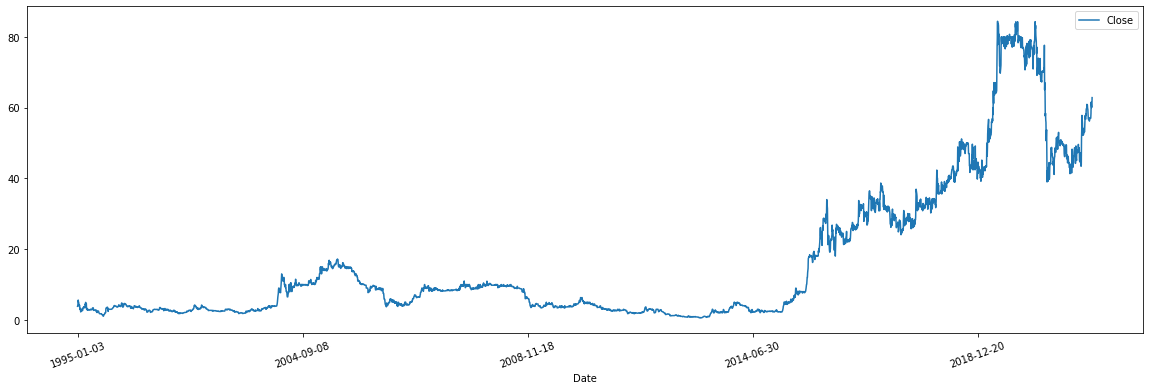

In [ ]:
# Creating a column as date
#StockData['TradeDate']=StockData.index

# Plotting the stock prices
%matplotlib inline
StockData.plot(x='Date', y='Close', kind='line', figsize=(20,6), rot=20)

# Preparing the data

In [ ]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[3.85]
 [4.05]
 [4.55]
 [5.6 ]
 [5.  ]]
### After Normalization ###


array([[0.03879207],
       [0.04117928],
       [0.04714729],
       [0.05968011],
       [0.0525185 ]])

# Preparing the data for LSTM

In [ ]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(4499, 10, 1)

#### Output Data shape ####
(4499, 1)


# Splitting Data into a Training set and a Test set

In [ ]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(4494, 10, 1)
(4494, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


#Visualizing the input and output data for LSTM

In [ ]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.03879207]
 [0.04117928]
 [0.04714729]
 [0.05968011]
 [0.0525185 ]
 [0.05180234]
 [0.04416328]
 [0.03938888]
 [0.04117928]
 [0.04237288]] -- [0.03043686]
[[0.04117928]
 [0.04714729]
 [0.05968011]
 [0.0525185 ]
 [0.05180234]
 [0.04416328]
 [0.03938888]
 [0.04117928]
 [0.04237288]
 [0.03043686]] -- [0.03222726]


#Creating the Deep Learning LSTM model

In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

regressor.save('ccc_model.h5')
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
899/899 [==============================] - 16s 12ms/step - loss: 0.0325
Epoch 2/100
899/899 [==============================] - 11s 12ms/step - loss: 6.1840e-04
Epoch 3/100
899/899 [==============================] - 11s 12ms/step - loss: 4.4110e-04
Epoch 4/100
899/899 [==============================] - 11s 12ms/step - loss: 5.3580e-04
Epoch 5/100
899/899 [==============================] - 11s 12ms/step - loss: 4.8273e-04
Epoch 6/100
899/899 [==============================] - 11s 12ms/step - loss: 4.9098e-04
Epoch 7/100
899/899 [==============================] - 11s 12ms/step - loss: 4.2244e-04
Epoch 8/100
899/899 [==============================] - 11s 12ms/step - loss: 3.0552e-04
Epoch 9/100
899/899 [==============================] - 11s 12ms/step - loss: 3.1760e-04
Epoch 10/100
899/899 [==============================] - 11s 12ms/step - loss: 2.9872e-04
Epoch 11/100
899/899 [==============================] - 11s 12ms/step - loss: 2.9991e-04
Epoch 12/100
899/899 [============

#Measuring the accuracy of the model on testing data

Accuracy: 97.48831571839372


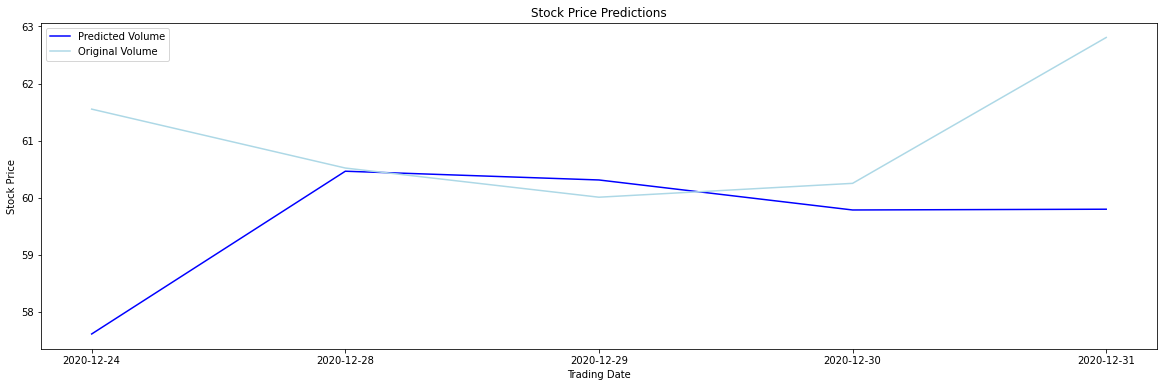

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

#Visualizing the predictions for full data

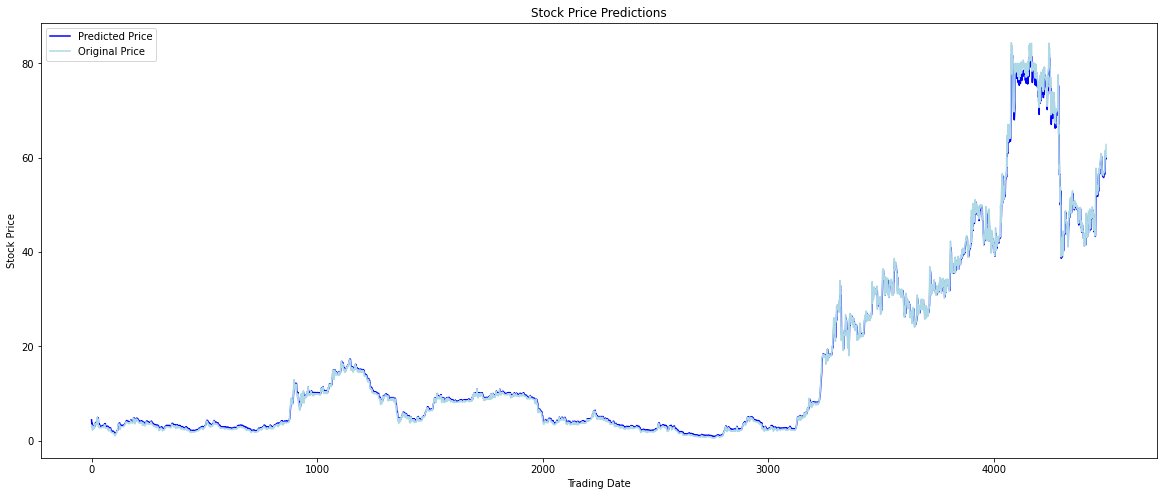

In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

#How to predict the stock price for tomorrow

In [ ]:
# Last 10 days prices
Last10Days=np.array([1002.15, 1009.9, 1007.5, 1019.75, 975.4,
            1011.45, 1010.4, 1009,1008.25, 1017.65])
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[22.270676]], dtype=float32)

#What If I want to predict prices for the next 5 days?

# Data Preparation for Multi Step LSTM

In [ ]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

print('###################')

# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[56.855308]
 [56.981636]
 [56.989664]
 [56.989118]
 [58.311118]
 [61.551857]
 [60.519899]
 [60.008883]
 [60.251705]
 [62.807004]]
###################
Scaled Prices
[0.67146465 0.6729725  0.67306832 0.6730618  0.68884123 0.72752276
 0.71520529 0.70910579 0.71200412 0.74250423]


In [ ]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(4494, 10, 1)
### Output Data Shape ###
(4494, 5)


# Splitting the data into Training and Testing

In [ ]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(4489, 10, 1)
(4489, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


#Visualizing the input->output sent to LSTM Multi-step model

In [ ]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.03879207]
 [0.04117928]
 [0.04714729]
 [0.05968011]
 [0.0525185 ]
 [0.05180234]
 [0.04416328]
 [0.03938888]
 [0.04117928]
 [0.04237288]]
====>
[0.03043686 0.03222726 0.02745285 0.02864646 0.01969444]
####################
[[0.04117928]
 [0.04714729]
 [0.05968011]
 [0.0525185 ]
 [0.05180234]
 [0.04416328]
 [0.03938888]
 [0.04117928]
 [0.04237288]
 [0.03043686]]
====>
[0.03222726 0.02745285 0.02864646 0.01969444 0.02315588]
####################


#Creating the Deep Learning Multi-Step LSTM model

In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')


Epoch 1/100
898/898 [==============================] - 17s 12ms/step - loss: 0.0396
Epoch 2/100
898/898 [==============================] - 11s 12ms/step - loss: 0.0011
Epoch 3/100
898/898 [==============================] - 11s 12ms/step - loss: 7.6778e-04
Epoch 4/100
898/898 [==============================] - 11s 12ms/step - loss: 6.9287e-04
Epoch 5/100
898/898 [==============================] - 11s 12ms/step - loss: 6.8516e-04
Epoch 6/100
898/898 [==============================] - 11s 12ms/step - loss: 6.5899e-04
Epoch 7/100
898/898 [==============================] - 11s 12ms/step - loss: 5.7048e-04
Epoch 8/100
898/898 [==============================] - 11s 12ms/step - loss: 6.1971e-04
Epoch 9/100
898/898 [==============================] - 11s 12ms/step - loss: 5.3762e-04
Epoch 10/100
898/898 [==============================] - 11s 12ms/step - loss: 5.5578e-04
Epoch 11/100
898/898 [==============================] - 11s 12ms/step - loss: 5.1278e-04
Epoch 12/100
898/898 [================

#Measuring the Accuracy of the model on testing data

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[58.314564 58.20109  58.045673 58.50699  58.721767]
 [58.146492 58.020115 57.8758   58.3197   58.523838]
 [58.24433  58.12266  57.97437  58.425484 58.633965]
 [58.28653  58.164818 58.016525 58.46807  58.676785]
 [58.27551  58.152813 58.005375 58.455616 58.663548]]

#### Original Prices ####
[[56.855308 56.981636 56.989664 56.989118 58.311118]
 [56.981636 56.989664 56.989118 58.311118 61.551857]
 [56.989664 56.989118 58.311118 61.551857 60.519899]
 [56.989118 58.311118 61.551857 60.519899 60.008883]
 [58.311118 61.551857 60.519899 60.008883 60.251705]]


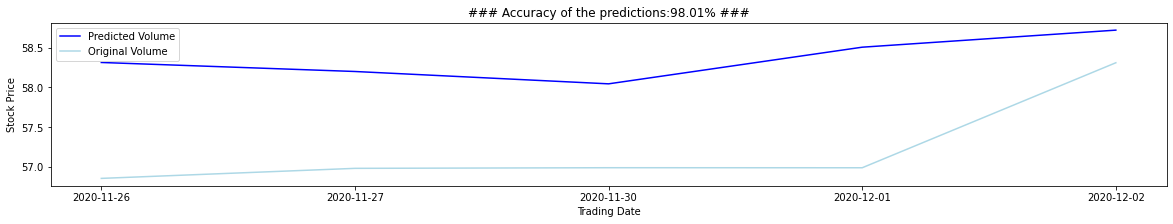

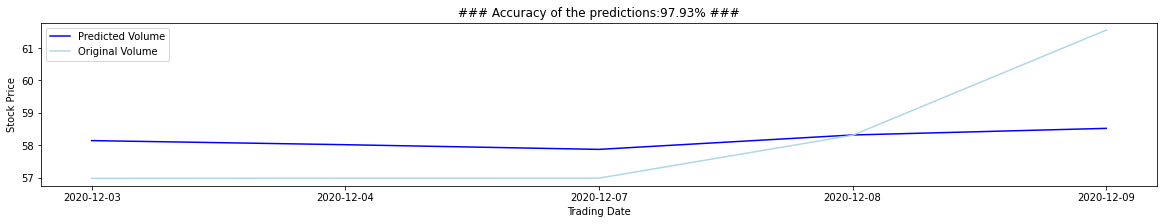

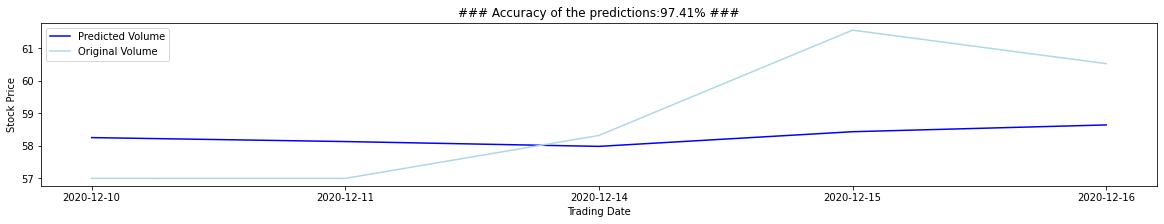

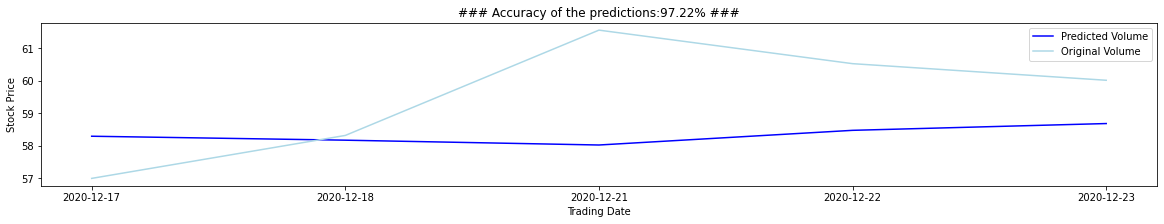

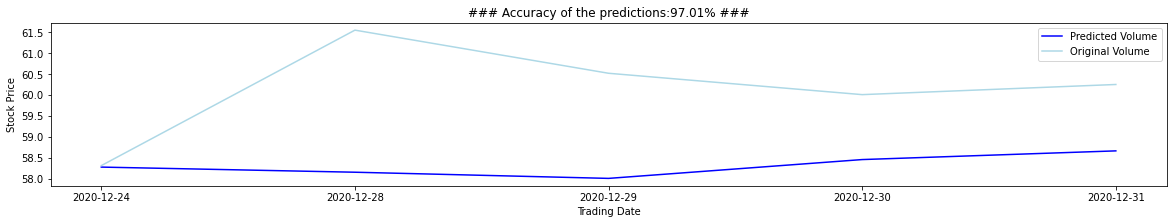

In [ ]:
import matplotlib.pyplot as plt
 
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
 
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

# Making predictions for the next 5 days

In [ ]:
# Making predictions on test data
Last10DaysPrices=np.array([1376.2, 1371.75,1387.15,1370.5 ,1344.95, 
                   1312.05, 1316.65, 1339.45, 1339.7 ,1340.85])
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[132.87416 ,  98.127785, 107.02937 , 137.87576 ,  80.44313 ]],
      dtype=float32)